<a href="https://colab.research.google.com/github/kylematoba/deeplearning-project/blob/master/keras_wide_res_net_matoba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# A heavily modified version of https://github.com/tail-island/try-wide-residual-net
!pip3 install funcy

In [0]:
import os
import sys
import shutil
import pickle
import copy
import functools
import logging

from typing import Any, Callable, List, Tuple, Union
from operator import getitem, attrgetter
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from PIL import ImageOps
from PIL import ImageEnhance
from PIL import ImageFilter
from PIL import Image

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input, Layer
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.train import AdadeltaOptimizer
# from tensorflow.keras.utils import plot_model

from funcy import concat, identity, juxt, partial, rcompose, repeat, repeatedly, take

from google.colab import auth
from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload, MediaIoBaseDownload

In [3]:
FORMAT = "%(asctime)s %(process)s %(thread)s: %(message)s"
logging.basicConfig(level=logging.DEBUG, format=FORMAT, stream=sys.stdout)
logger = logging.getLogger(__name__)

environ_dict = dict(os.environ)
use_tpu = 'COLAB_TPU_ADDR' in environ_dict.keys()

logger.info(sys.version)
logger.info("{}".format("Running in ipython" if 'ipykernel' in sys.modules else ""))
logger.info("Numpy version {}".format(np.__version__))
logger.info("TensorFlow version {}".format(tf.__version__))
if use_tpu:
    logger.info("Running on TPU")

2018-12-06 21:19:46,660 69 140155896297344: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
2018-12-06 21:19:46,663 69 140155896297344: Running in ipython
2018-12-06 21:19:46,673 69 140155896297344: Numpy version 1.14.6
2018-12-06 21:19:46,674 69 140155896297344: TensorFlow version 1.12.0
2018-12-06 21:19:46,677 69 140155896297344: Running on TPU


In [0]:
def download_data() -> None:
    url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    shutil.copytree(tf.keras.utils.get_file('cifar-10-batches-py', origin=url, untar=True), './data')

    
def load_batch(batch_path: str) -> Tuple[np.ndarray, np.ndarray]:
    with open(batch_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    data_np = np.array(batch[b'data'])
    labels_np = np.array(batch[b'labels'])
    batch_data = data_np.reshape(data_np.shape[0], 3, 32, 32).transpose(0, 2, 3, 1) / 255
    batch_labels = tf.keras.utils.to_categorical(labels_np)
    return (batch_data, batch_labels)


def load_batches(paths: List[str]):
    return tuple(map(np.concatenate, zip(*map(load_batch, paths))))


def load_data(data_path='./data') -> Tuple[np.ndarray, np.ndarray]:
    if not os.path.exists('./data'):
        download_data()
    paths = sorted(map(attrgetter('path'), filter(lambda directory_entry: directory_entry.name.startswith('data_batch_'), os.scandir(data_path))))
    xy_train = load_batches(paths)
    xy_validation = load_batch('{0}/test_batch'.format(data_path))
    return (xy_train, xy_validation)

In [0]:
def computational_graph(class_size):
    def ljuxt(*fs):
        return rcompose(juxt(*fs), list)

    def batch_normalization():
        return BatchNormalization()

    def relu() -> tf.keras.layers.Activation:
        return Activation('relu')

    def conv(filter_size: int, kernel_size: int, stride_size: int=1) -> Layer:
        return Conv2D(filter_size, kernel_size, strides=stride_size, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), use_bias=False)

    def add():
        return Add()

    def global_average_pooling():
        return GlobalAveragePooling2D()

    def dense(units: int, activation: str) -> Layer:
        return Dense(units, activation=activation, kernel_regularizer=l2(0.0005))

    # Define WRN-28-10.
    def first_residual_unit(filter_size: int, stride_size: int):
        return rcompose(batch_normalization(),
                        relu(),
                        ljuxt(rcompose(conv(filter_size, 3, stride_size),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3, 1)),
                              rcompose(conv(filter_size, 1, stride_size))),
                        add())

    def residual_unit(filter_size):
        return rcompose(ljuxt(rcompose(batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3),
                                       batch_normalization(),
                                       relu(),
                                       conv(filter_size, 3)),
                              identity),
                        add())

    def residual_block(filter_size, stride_size, unit_size):
        return rcompose(first_residual_unit(filter_size, stride_size),
                        rcompose(*repeatedly(partial(residual_unit, filter_size), unit_size - 1)))

    k = 10
    n =  4
    return rcompose(conv(16, 3),
                    residual_block(16 * k, 1, n),
                    residual_block(32 * k, 2, n),
                    residual_block(64 * k, 2, n),
                    batch_normalization(),
                    relu(),
                    global_average_pooling(),
                    dense(class_size, 'softmax'))

In [6]:
(x_train, y_train), (x_validation, y_validation) = load_data()

170500096/170498071 [==============================] - 21s 0us/step


In [0]:
# A Folder or File in your Google Drive
GDriveItem = namedtuple('GDriveItem', ['name', 'fid'])

# Epoch information as returned from keras
EpochData = namedtuple('EpochData', ['epoch', 'losses'])


class GDriveSync:
    """
    Simple up/downloading functionality to move local files into the cloud and vice versa.
    """
    def __init__(self):
        auth.authenticate_user()  # prompt the user to access his Google Drive via the API
        self.drive_service = build('drive', 'v3')
        self.default_folder = self.find_items('Colab Notebooks')[0]

    def find_items(self, name: str) -> List[str]:
        """
        Find folders or files based on their name. This always searches the full Google Drive tree!
        :param name: Term to be searched. All files containing this search term are returned.
        """
        folder_list = self.drive_service.files().list(q='name contains "%s"' % name).execute()
        folders = []
        for folder in folder_list['files']:
            folders.append(GDriveItem(folder['name'], folder['id']))
        return folders

    def upload_file_to_folder(self, local_file: str, folder=None) -> None:
        """
        Upload a local file, optionally to a specific folder in Google Drive
        :param local_file: Path to the local file
        :param folder: (Option) GDriveItem which should be the parent.
        """
        if folder is not None:
            assert type(folder) == GDriveItem	

        file_metadata = {
            'title': local_file,
            'name': local_file
        }

        if folder is not None:
            file_metadata['parents'] = [folder.fid]

        media = MediaFileUpload(local_file, resumable=True)
        created = self.drive_service.files().create(body=file_metadata,
                                                    media_body=media,
                                                    fields='id')
        if folder is not None:
            d = 'Uploading file %s to folder %s' % (local_file, folder.name)
        else:
            d = 'Uploading file %s' % local_file

        response = None
        while response is None:
            status, response = created.next_chunk()
                
    def download_file_to_folder(self, 
                                remote_file: GDriveItem, 
                                path: str) -> None:
        assert type(remote_file) == GDriveItem
        request = self.drive_service.files().get_media(fileId=remote_file.fid)

        with open(path, 'wb') as fh:
            downloader = MediaIoBaseDownload(fh, request)
            done = False
            while done is False:
                status, done = downloader.next_chunk()

    def delete_file(self, file: GDriveItem) -> None:
        assert type(file) == GDriveItem
        request = self.drive_service.files().delete(fileId=file.fid)
        request.execute()


class GDriveCheckpointer(tf.keras.callbacks.Callback):
    """
    Keras Callback that automatically saves models into your Google Drive.
    Outdated checkpoints are automatically deleted remotely to prevent GDrive from filling up.
    Checkpointing is controlled by two functions:
        compare_fn(best_epoch: EpochData, current_epoch: EpochData) -> bool
        - If this function returns true, the current_epoch is assumed to have better performance than the older best_epoch.
        - e.g. return best_epoch.losses['val_acc'] < current_epoch.losses['val_acc']
        filepath_fn(epoch: EpochData) -> Union[String, None]
        - If this function returns None, the checkpoint is skipped. This can be used to skip backing up early epochs.
          If it returns a String path, the model is uploaded into the default GDrive folder with the given file name.
    """
    def __init__(self, 
                 compare_fn: Callable, 
                 filepath_fn: Callable, 
                 save_optimizer=False):
        assert compare_fn is not None, 'Need a compare function which gets all the losses and evaluation data of two epochs and which needs to return True if the second one is better.'
        assert filepath_fn is not None, 'Need a function that derives a file path based on a dictionary of losses and metrics.'

        restart_from_backup = False
        super(GDriveCheckpointer, self).__init__()
        self.saver = GDriveSync()
        self.compare_fn = compare_fn
        self.filepath_fn = filepath_fn
        self.best_epoch = None
        self.best_filename = None
        self.save_optimizer = save_optimizer

    def on_epoch_end(self, epoch: int, logs={}):
        losses = dict(logs)
        epoch_data = EpochData(epoch, losses)
        if self.best_epoch is None or self.compare_fn(self.best_epoch, epoch_data):
            self.best_epoch = copy.deepcopy(epoch_data)
            fn = self.filepath_fn(epoch_data)
            if fn is not None and fn:
                if self.best_filename:
                    os.remove(self.best_filename)
                    all_found = self.saver.find_items(self.best_filename)
                    old_file = all_found[0]
                    print('Removing old cloud file %s' % old_file.name)
                    self.saver.delete_file(old_file)
                self.best_filename = fn
                self._save_checkpoint()
            else:
                print('Skipping upload because path function returned no path.')
        else:
            pass

    def _save_checkpoint(self):
        print('Saving {}'.format(self.best_filename))
        self.model.save(self.best_filename)
        print('Uploading to {}'.format(self.saver.default_folder))
        self.saver.upload_file_to_folder(self.best_filename, self.saver.default_folder)
        

In [0]:
def filepath_fn_unbound(filebase: str, 
                        x: EpochData) -> Union[str, None]:
    filepath = '{}_{:04d}'.format(filebase, x.epoch)
    return filepath
  

def compare_fn(best_epoch: EpochData, 
               current_epoch: EpochData) -> bool:
    save_every = 10
    save = 0 == current_epoch.epoch % save_every
    return save
  

# filebase = 'wide_res_net'
filebase = 'autoaugment'
filepath_fn = lambda x: filepath_fn_unbound(filebase, x)

In [0]:
# this one prompts for authorisation
gdcp = GDriveCheckpointer(compare_fn, filepath_fn)
# gdcp

In [11]:
def get_last_filename(filebase: str) -> str:
    remote_files = gdcp.saver.find_items(filebase)
    sorted_filenames = sorted([x.name for x in remote_files])
    if len(sorted_filenames) > 0:
        last_filename = sorted_filenames[-1]
    else:
        last_filename = None
    return last_filename

attempt_reload_from_drive = True
reload_from = '0290'
last_filename = get_last_filename(filebase)

if attempt_reload_from_drive and (last_filename is not None):
  remote_files = gdcp.saver.find_items(last_filename)
  remote_file = remote_files[0]
  local_best_model_fn = remote_file.name
  logger.info("Loading from {}".format(local_best_model_fn))
  gdcp.saver.download_file_to_folder(remote_file, local_best_model_fn)
  model = load_model(local_best_model_fn)
  initial_epoch = int(remote_file.name.split('_')[-1])
else:  
  print('new')
  xshape = x_train.shape[1:]
  yshape = y_train.shape[1]
  model = Model(*juxt(identity, computational_graph(yshape))(Input(shape=xshape)))
  optimizer = SGD() #AdadeltaOptimizer()
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  initial_epoch = 0

2018-12-06 21:21:53,346 69 140155896297344: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22autoaugment%22&alt=json
2018-12-06 21:21:53,581 69 140155896297344: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22autoaugment_0290%22&alt=json
2018-12-06 21:21:53,759 69 140155896297344: Loading from autoaugment_0290
2018-12-06 21:21:53,764 69 140155896297344: URL being requested: GET https://www.googleapis.com/drive/v3/files/1D0JuCQfvGgLdQ6XbiO_baz126HnIDsIU?alt=media


In [13]:
remote_files = gdcp.saver.find_items(filebase)
sorted_filenames = sorted([x.name for x in remote_files])
if len(sorted_filenames) > 0:
    last_filename = sorted_filenames[-1]
else:
    last_filename = None
print(sorted_filenames)

# to_delete = gdcp.find_items()
# gdcp.drive_service.files().delete(fileId=file.fid)

2018-12-05 22:14:44,756 183 139789618734976: URL being requested: GET https://www.googleapis.com/drive/v3/files?q=name+contains+%22autoaugment%22&alt=json
['___autoaugment_0090___']


In [0]:
PARAMETER_MAX = 10 


def float_parameter(level, maxval):
    return float(level) * maxval / PARAMETER_MAX


def int_parameter(level, maxval):
    return int(level * maxval / PARAMETER_MAX)

  
def create_cutout_mask(img_height, img_width, num_channels, size):
    """Creates a zero mask used for cutout of shape `img_height` x `img_width`.

    Args:
      img_height: Height of image cutout mask will be applied to.
      img_width: Width of image cutout mask will be applied to.
      num_channels: Number of channels in the image.
      size: Size of the zeros mask.

    Returns:
      A mask of shape `img_height` x `img_width` with all ones except for a
      square of zeros of shape `size` x `size`. This mask is meant to be
      elementwise multiplied with the original image. Additionally returns
      the `upper_coord` and `lower_coord` which specify where the cutout mask
      will be applied.
    """
    assert img_height == img_width

    # Sample center where cutout mask will be applied
    height_loc = np.random.randint(low=0, high=img_height)
    width_loc = np.random.randint(low=0, high=img_width)

    # Determine upper right and lower left corners of patch
    upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
    lower_coord = (min(img_height, height_loc + size // 2), min(img_width, width_loc + size // 2))
    mask_height = lower_coord[0] - upper_coord[0]
    mask_width = lower_coord[1] - upper_coord[1]
    assert mask_height > 0
    assert mask_width > 0

    mask = np.ones((img_height, img_width, num_channels))
    zeros = np.zeros((mask_height, mask_width, num_channels))
    mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (zeros)
    return mask, upper_coord, lower_coord


def cutout_numpy(img, size=16):
    """Apply cutout with mask of shape `size` x `size` to `img`.

    The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
    This operation applies a `size`x`size` mask of zeros to a random location
    within `img`.

    Args:
      img: Numpy image that cutout will be applied to.
      size: Height/width of the cutout mask that will be

    Returns:
      A numpy tensor that is the result of applying the cutout mask to `img`.
    """
    img_height, img_width, num_channels = (img.shape[0], img.shape[1], img.shape[2])
    assert len(img.shape) == 3
    mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
    return img * mask

  
def random_flip(x):
    """Flip the input x horizontally with 50% probability."""
    if np.random.rand(1)[0] > 0.5:
        return np.fliplr(x)
    return x


def zero_pad_and_crop(img, amount=4):
    """Zero pad by `amount` zero pixels on each side then take a random crop.
    Args:
      img: numpy image that will be zero padded and cropped.
      amount: amount of zeros to pad `img` with horizontally and verically.

    Returns:
      The cropped zero padded img. The returned numpy array will be of the same
      shape as `img`.
    """
    padded_img = np.zeros((img.shape[0] + amount * 2, img.shape[1] + amount * 2, img.shape[2]))
    padded_img[amount:img.shape[0] + amount, amount:img.shape[1] + amount, :] = img
    top = np.random.randint(low=0, high=2 * amount)
    left = np.random.randint(low=0, high=2 * amount)
    new_img = padded_img[top:top + img.shape[0], left:left + img.shape[1], :]
    return new_img
  

In [0]:
# Copyright 2018 The TensorFlow Authors All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Transforms used in the Augmentation Policies."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import random
import numpy as np
# pylint:disable=g-multiple-import
from PIL import ImageOps, ImageEnhance, ImageFilter, Image
# pylint:enable=g-multiple-import


IMAGE_SIZE = 32
# What is the dataset mean and std of the images on the training set
MEANS = [0.49139968, 0.48215841, 0.44653091]
STDS = [0.24703223, 0.24348513, 0.26158784]
PARAMETER_MAX = 10  # What is the max 'level' a transform could be predicted


def random_flip(x):
  """Flip the input x horizontally with 50% probability."""
  if np.random.rand(1)[0] > 0.5:
    return np.fliplr(x)
  return x


def zero_pad_and_crop(img, amount=4):
  """Zero pad by `amount` zero pixels on each side then take a random crop.

  Args:
    img: numpy image that will be zero padded and cropped.
    amount: amount of zeros to pad `img` with horizontally and verically.

  Returns:
    The cropped zero padded img. The returned numpy array will be of the same
    shape as `img`.
  """
  padded_img = np.zeros((img.shape[0] + amount * 2, img.shape[1] + amount * 2,
                         img.shape[2]))
  padded_img[amount:img.shape[0] + amount, amount:
             img.shape[1] + amount, :] = img
  top = np.random.randint(low=0, high=2 * amount)
  left = np.random.randint(low=0, high=2 * amount)
  new_img = padded_img[top:top + img.shape[0], left:left + img.shape[1], :]
  return new_img


def create_cutout_mask(img_height, img_width, num_channels, size):
  """Creates a zero mask used for cutout of shape `img_height` x `img_width`.

  Args:
    img_height: Height of image cutout mask will be applied to.
    img_width: Width of image cutout mask will be applied to.
    num_channels: Number of channels in the image.
    size: Size of the zeros mask.

  Returns:
    A mask of shape `img_height` x `img_width` with all ones except for a
    square of zeros of shape `size` x `size`. This mask is meant to be
    elementwise multiplied with the original image. Additionally returns
    the `upper_coord` and `lower_coord` which specify where the cutout mask
    will be applied.
  """
  assert img_height == img_width

  # Sample center where cutout mask will be applied
  height_loc = np.random.randint(low=0, high=img_height)
  width_loc = np.random.randint(low=0, high=img_width)

  # Determine upper right and lower left corners of patch
  upper_coord = (max(0, height_loc - size // 2), max(0, width_loc - size // 2))
  lower_coord = (min(img_height, height_loc + size // 2),
                 min(img_width, width_loc + size // 2))
  mask_height = lower_coord[0] - upper_coord[0]
  mask_width = lower_coord[1] - upper_coord[1]
  assert mask_height > 0
  assert mask_width > 0

  mask = np.ones((img_height, img_width, num_channels))
  zeros = np.zeros((mask_height, mask_width, num_channels))
  mask[upper_coord[0]:lower_coord[0], upper_coord[1]:lower_coord[1], :] = (
      zeros)
  return mask, upper_coord, lower_coord


def cutout_numpy(img, size=16):
  """Apply cutout with mask of shape `size` x `size` to `img`.

  The cutout operation is from the paper https://arxiv.org/abs/1708.04552.
  This operation applies a `size`x`size` mask of zeros to a random location
  within `img`.

  Args:
    img: Numpy image that cutout will be applied to.
    size: Height/width of the cutout mask that will be

  Returns:
    A numpy tensor that is the result of applying the cutout mask to `img`.
  """
  img_height, img_width, num_channels = (img.shape[0], img.shape[1],
                                         img.shape[2])
  assert len(img.shape) == 3
  mask, _, _ = create_cutout_mask(img_height, img_width, num_channels, size)
  return img * mask


def float_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.

  Returns:
    A float that results from scaling `maxval` according to `level`.
  """
  return float(level) * maxval / PARAMETER_MAX


def int_parameter(level, maxval):
  """Helper function to scale `val` between 0 and maxval .

  Args:
    level: Level of the operation that will be between [0, `PARAMETER_MAX`].
    maxval: Maximum value that the operation can have. This will be scaled
      to level/PARAMETER_MAX.

  Returns:
    An int that results from scaling `maxval` according to `level`.
  """
  return int(level * maxval / PARAMETER_MAX)


def pil_wrap(img):
  """Convert the `img` numpy tensor to a PIL Image."""
  return Image.fromarray(
      np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')


def pil_unwrap(pil_img):
  """Converts the PIL img to a numpy array."""
  pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
  i1, i2 = np.where(pic_array[:, :, 3] == 0)
  pic_array = (pic_array[:, :, :3] - MEANS) / STDS
  pic_array[i1, i2] = [0, 0, 0]
  return pic_array


def apply_policy(policy, img):
  """Apply the `policy` to the numpy `img`.

  Args:
    policy: A list of tuples with the form (name, probability, level) where
      `name` is the name of the augmentation operation to apply, `probability`
      is the probability of applying the operation and `level` is what strength
      the operation to apply.
    img: Numpy image that will have `policy` applied to it.

  Returns:
    The result of applying `policy` to `img`.
  """
  pil_img = pil_wrap(img)
  for xform in policy:
    assert len(xform) == 3
    name, probability, level = xform
    xform_fn = NAME_TO_TRANSFORM[name].pil_transformer(probability, level)
    pil_img = xform_fn(pil_img)
  return pil_unwrap(pil_img)


class TransformFunction(object):
  """Wraps the Transform function for pretty printing options."""

  def __init__(self, func, name):
    self.f = func
    self.name = name

  def __repr__(self):
    return '<' + self.name + '>'

  def __call__(self, pil_img):
    return self.f(pil_img)


class TransformT(object):
  """Each instance of this class represents a specific transform."""

  def __init__(self, name, xform_fn):
    self.name = name
    self.xform = xform_fn

  def pil_transformer(self, probability, level):

    def return_function(im):
      if random.random() < probability:
        im = self.xform(im, level)
      return im

    name = self.name + '({:.1f},{})'.format(probability, level)
    return TransformFunction(return_function, name)

  def do_transform(self, image, level):
    f = self.pil_transformer(PARAMETER_MAX, level)
    return pil_unwrap(f(pil_wrap(image)))


################## Transform Functions ##################
identity = TransformT('identity', lambda pil_img, level: pil_img)
flip_lr = TransformT(
    'FlipLR',
    lambda pil_img, level: pil_img.transpose(Image.FLIP_LEFT_RIGHT))
flip_ud = TransformT(
    'FlipUD',
    lambda pil_img, level: pil_img.transpose(Image.FLIP_TOP_BOTTOM))
# pylint:disable=g-long-lambda
auto_contrast = TransformT(
    'AutoContrast',
    lambda pil_img, level: ImageOps.autocontrast(
        pil_img.convert('RGB')).convert('RGBA'))
equalize = TransformT(
    'Equalize',
    lambda pil_img, level: ImageOps.equalize(
        pil_img.convert('RGB')).convert('RGBA'))
invert = TransformT(
    'Invert',
    lambda pil_img, level: ImageOps.invert(
        pil_img.convert('RGB')).convert('RGBA'))
# pylint:enable=g-long-lambda
blur = TransformT(
    'Blur', lambda pil_img, level: pil_img.filter(ImageFilter.BLUR))
smooth = TransformT(
    'Smooth',
    lambda pil_img, level: pil_img.filter(ImageFilter.SMOOTH))


def _rotate_impl(pil_img, level):
  """Rotates `pil_img` from -30 to 30 degrees depending on `level`."""
  degrees = int_parameter(level, 30)
  if random.random() > 0.5:
    degrees = -degrees
  return pil_img.rotate(degrees)


rotate = TransformT('Rotate', _rotate_impl)


def _posterize_impl(pil_img, level):
  """Applies PIL Posterize to `pil_img`."""
  level = int_parameter(level, 4)
  return ImageOps.posterize(pil_img.convert('RGB'), 4 - level).convert('RGBA')


posterize = TransformT('Posterize', _posterize_impl)


def _shear_x_impl(pil_img, level):
  """Applies PIL ShearX to `pil_img`.

  The ShearX operation shears the image along the horizontal axis with `level`
  magnitude.

  Args:
    pil_img: Image in PIL object.
    level: Strength of the operation specified as an Integer from
      [0, `PARAMETER_MAX`].

  Returns:
    A PIL Image that has had ShearX applied to it.
  """
  level = float_parameter(level, 0.3)
  if random.random() > 0.5:
    level = -level
  return pil_img.transform((32, 32), Image.AFFINE, (1, level, 0, 0, 1, 0))


shear_x = TransformT('ShearX', _shear_x_impl)


def _shear_y_impl(pil_img, level):
  """Applies PIL ShearY to `pil_img`.

  The ShearY operation shears the image along the vertical axis with `level`
  magnitude.

  Args:
    pil_img: Image in PIL object.
    level: Strength of the operation specified as an Integer from
      [0, `PARAMETER_MAX`].

  Returns:
    A PIL Image that has had ShearX applied to it.
  """
  level = float_parameter(level, 0.3)
  if random.random() > 0.5:
    level = -level
  return pil_img.transform((32, 32), Image.AFFINE, (1, 0, 0, level, 1, 0))


shear_y = TransformT('ShearY', _shear_y_impl)


def _translate_x_impl(pil_img, level):
  """Applies PIL TranslateX to `pil_img`.

  Translate the image in the horizontal direction by `level`
  number of pixels.

  Args:
    pil_img: Image in PIL object.
    level: Strength of the operation specified as an Integer from
      [0, `PARAMETER_MAX`].

  Returns:
    A PIL Image that has had TranslateX applied to it.
  """
  level = int_parameter(level, 10)
  if random.random() > 0.5:
    level = -level
  return pil_img.transform((32, 32), Image.AFFINE, (1, 0, level, 0, 1, 0))


translate_x = TransformT('TranslateX', _translate_x_impl)


def _translate_y_impl(pil_img, level):
  """Applies PIL TranslateY to `pil_img`.

  Translate the image in the vertical direction by `level`
  number of pixels.

  Args:
    pil_img: Image in PIL object.
    level: Strength of the operation specified as an Integer from
      [0, `PARAMETER_MAX`].

  Returns:
    A PIL Image that has had TranslateY applied to it.
  """
  level = int_parameter(level, 10)
  if random.random() > 0.5:
    level = -level
  return pil_img.transform((32, 32), Image.AFFINE, (1, 0, 0, 0, 1, level))


translate_y = TransformT('TranslateY', _translate_y_impl)


def _crop_impl(pil_img, level, interpolation=Image.BILINEAR):
  """Applies a crop to `pil_img` with the size depending on the `level`."""
  cropped = pil_img.crop((level, level, IMAGE_SIZE - level, IMAGE_SIZE - level))
  resized = cropped.resize((IMAGE_SIZE, IMAGE_SIZE), interpolation)
  return resized


crop_bilinear = TransformT('CropBilinear', _crop_impl)


def _solarize_impl(pil_img, level):
  """Applies PIL Solarize to `pil_img`.

  Translate the image in the vertical direction by `level`
  number of pixels.

  Args:
    pil_img: Image in PIL object.
    level: Strength of the operation specified as an Integer from
      [0, `PARAMETER_MAX`].

  Returns:
    A PIL Image that has had Solarize applied to it.
  """
  level = int_parameter(level, 256)
  return ImageOps.solarize(pil_img.convert('RGB'), 256 - level).convert('RGBA')


solarize = TransformT('Solarize', _solarize_impl)


def _cutout_pil_impl(pil_img, level):
  """Apply cutout to pil_img at the specified level."""
  size = int_parameter(level, 20)
  if size <= 0:
    return pil_img
  img_height, img_width, num_channels = (32, 32, 3)
  _, upper_coord, lower_coord = (
      create_cutout_mask(img_height, img_width, num_channels, size))
  pixels = pil_img.load()  # create the pixel map
  for i in range(upper_coord[0], lower_coord[0]):  # for every col:
    for j in range(upper_coord[1], lower_coord[1]):  # For every row
      pixels[i, j] = (125, 122, 113, 0)  # set the colour accordingly
  return pil_img

cutout = TransformT('Cutout', _cutout_pil_impl)


def _enhancer_impl(enhancer):
  """Sets level to be between 0.1 and 1.8 for ImageEnhance transforms of PIL."""
  def impl(pil_img, level):
    v = float_parameter(level, 1.8) + .1  # going to 0 just destroys it
    return enhancer(pil_img).enhance(v)
  return impl


color = TransformT('Color', _enhancer_impl(ImageEnhance.Color))
contrast = TransformT('Contrast', _enhancer_impl(ImageEnhance.Contrast))
brightness = TransformT('Brightness', _enhancer_impl(
    ImageEnhance.Brightness))
sharpness = TransformT('Sharpness', _enhancer_impl(ImageEnhance.Sharpness))

ALL_TRANSFORMS = [
    flip_lr,
    flip_ud,
    auto_contrast,
    equalize,
    invert,
    rotate,
    posterize,
    crop_bilinear,
    solarize,
    color,
    contrast,
    brightness,
    sharpness,
    shear_x,
    shear_y,
    translate_x,
    translate_y,
    cutout,
    blur,
    smooth
]

NAME_TO_TRANSFORM = {t.name: t for t in ALL_TRANSFORMS}
TRANSFORM_NAMES = NAME_TO_TRANSFORM.keys()


In [14]:
# !git clone https://github.com/tensorflow/models.git

def return_good_policies() -> List[tuple]:
    """AutoAugment policies found on analysis."""
    exp0_0 = [
      [('Invert', 0.1, 7), ('Contrast', 0.2, 6)],
      [('Rotate', 0.7, 2), ('TranslateX', 0.3, 9)],
      [('Sharpness', 0.8, 1), ('Sharpness', 0.9, 3)],
      [('ShearY', 0.5, 8), ('TranslateY', 0.7, 9)],
      [('AutoContrast', 0.5, 8), ('Equalize', 0.9, 2)]]
    exp0_1 = [
      [('Solarize', 0.4, 5), ('AutoContrast', 0.9, 3)],
      [('TranslateY', 0.9, 9), ('TranslateY', 0.7, 9)],
      [('AutoContrast', 0.9, 2), ('Solarize', 0.8, 3)],
      [('Equalize', 0.8, 8), ('Invert', 0.1, 3)],
      [('TranslateY', 0.7, 9), ('AutoContrast', 0.9, 1)]]
    exp0_2 = [
      [('Solarize', 0.4, 5), ('AutoContrast', 0.0, 2)],
      [('TranslateY', 0.7, 9), ('TranslateY', 0.7, 9)],
      [('AutoContrast', 0.9, 0), ('Solarize', 0.4, 3)],
      [('Equalize', 0.7, 5), ('Invert', 0.1, 3)],
      [('TranslateY', 0.7, 9), ('TranslateY', 0.7, 9)]]
    exp0_3 = [
      [('Solarize', 0.4, 5), ('AutoContrast', 0.9, 1)],
      [('TranslateY', 0.8, 9), ('TranslateY', 0.9, 9)],
      [('AutoContrast', 0.8, 0), ('TranslateY', 0.7, 9)],
      [('TranslateY', 0.2, 7), ('Color', 0.9, 6)],
      [('Equalize', 0.7, 6), ('Color', 0.4, 9)]]
    exp1_0 = [
      [('ShearY', 0.2, 7), ('Posterize', 0.3, 7)],
      [('Color', 0.4, 3), ('Brightness', 0.6, 7)],
      [('Sharpness', 0.3, 9), ('Brightness', 0.7, 9)],
      [('Equalize', 0.6, 5), ('Equalize', 0.5, 1)],
      [('Contrast', 0.6, 7), ('Sharpness', 0.6, 5)]]
    exp1_1 = [
      [('Brightness', 0.3, 7), ('AutoContrast', 0.5, 8)],
      [('AutoContrast', 0.9, 4), ('AutoContrast', 0.5, 6)],
      [('Solarize', 0.3, 5), ('Equalize', 0.6, 5)],
      [('TranslateY', 0.2, 4), ('Sharpness', 0.3, 3)],
      [('Brightness', 0.0, 8), ('Color', 0.8, 8)]]
    exp1_2 = [
      [('Solarize', 0.2, 6), ('Color', 0.8, 6)],
      [('Solarize', 0.2, 6), ('AutoContrast', 0.8, 1)],
      [('Solarize', 0.4, 1), ('Equalize', 0.6, 5)],
      [('Brightness', 0.0, 0), ('Solarize', 0.5, 2)],
      [('AutoContrast', 0.9, 5), ('Brightness', 0.5, 3)]]
    exp1_3 = [
      [('Contrast', 0.7, 5), ('Brightness', 0.0, 2)],
      [('Solarize', 0.2, 8), ('Solarize', 0.1, 5)],
      [('Contrast', 0.5, 1), ('TranslateY', 0.2, 9)],
      [('AutoContrast', 0.6, 5), ('TranslateY', 0.0, 9)],
      [('AutoContrast', 0.9, 4), ('Equalize', 0.8, 4)]]
    exp1_4 = [
      [('Brightness', 0.0, 7), ('Equalize', 0.4, 7)],
      [('Solarize', 0.2, 5), ('Equalize', 0.7, 5)],
      [('Equalize', 0.6, 8), ('Color', 0.6, 2)],
      [('Color', 0.3, 7), ('Color', 0.2, 4)],
      [('AutoContrast', 0.5, 2), ('Solarize', 0.7, 2)]]
    exp1_5 = [
      [('AutoContrast', 0.2, 0), ('Equalize', 0.1, 0)],
      [('ShearY', 0.6, 5), ('Equalize', 0.6, 5)],
      [('Brightness', 0.9, 3), ('AutoContrast', 0.4, 1)],
      [('Equalize', 0.8, 8), ('Equalize', 0.7, 7)],
      [('Equalize', 0.7, 7), ('Solarize', 0.5, 0)]]
    exp1_6 = [
      [('Equalize', 0.8, 4), ('TranslateY', 0.8, 9)],
      [('TranslateY', 0.8, 9), ('TranslateY', 0.6, 9)],
      [('TranslateY', 0.9, 0), ('TranslateY', 0.5, 9)],
      [('AutoContrast', 0.5, 3), ('Solarize', 0.3, 4)],
      [('Solarize', 0.5, 3), ('Equalize', 0.4, 4)]]
    exp2_0 = [
      [('Color', 0.7, 7), ('TranslateX', 0.5, 8)],
      [('Equalize', 0.3, 7), ('AutoContrast', 0.4, 8)],
      [('TranslateY', 0.4, 3), ('Sharpness', 0.2, 6)],
      [('Brightness', 0.9, 6), ('Color', 0.2, 8)],
      [('Solarize', 0.5, 2), ('Invert', 0.0, 3)]]
    exp2_1 = [
      [('AutoContrast', 0.1, 5), ('Brightness', 0.0, 0)],
      [('Cutout', 0.2, 4), ('Equalize', 0.1, 1)],
      [('Equalize', 0.7, 7), ('AutoContrast', 0.6, 4)],
      [('Color', 0.1, 8), ('ShearY', 0.2, 3)],
      [('ShearY', 0.4, 2), ('Rotate', 0.7, 0)]]
    exp2_2 = [
      [('ShearY', 0.1, 3), ('AutoContrast', 0.9, 5)],
      [('TranslateY', 0.3, 6), ('Cutout', 0.3, 3)],
      [('Equalize', 0.5, 0), ('Solarize', 0.6, 6)],
      [('AutoContrast', 0.3, 5), ('Rotate', 0.2, 7)],
      [('Equalize', 0.8, 2), ('Invert', 0.4, 0)]]
    exp2_3 = [
      [('Equalize', 0.9, 5), ('Color', 0.7, 0)],
      [('Equalize', 0.1, 1), ('ShearY', 0.1, 3)],
      [('AutoContrast', 0.7, 3), ('Equalize', 0.7, 0)],
      [('Brightness', 0.5, 1), ('Contrast', 0.1, 7)],
      [('Contrast', 0.1, 4), ('Solarize', 0.6, 5)]]
    exp2_4 = [
      [('Solarize', 0.2, 3), ('ShearX', 0.0, 0)],
      [('TranslateX', 0.3, 0), ('TranslateX', 0.6, 0)],
      [('Equalize', 0.5, 9), ('TranslateY', 0.6, 7)],
      [('ShearX', 0.1, 0), ('Sharpness', 0.5, 1)],
      [('Equalize', 0.8, 6), ('Invert', 0.3, 6)]]
    exp2_5 = [
      [('AutoContrast', 0.3, 9), ('Cutout', 0.5, 3)],
      [('ShearX', 0.4, 4), ('AutoContrast', 0.9, 2)],
      [('ShearX', 0.0, 3), ('Posterize', 0.0, 3)],
      [('Solarize', 0.4, 3), ('Color', 0.2, 4)],
      [('Equalize', 0.1, 4), ('Equalize', 0.7, 6)]]
    exp2_6 = [
      [('Equalize', 0.3, 8), ('AutoContrast', 0.4, 3)],
      [('Solarize', 0.6, 4), ('AutoContrast', 0.7, 6)],
      [('AutoContrast', 0.2, 9), ('Brightness', 0.4, 8)],
      [('Equalize', 0.1, 0), ('Equalize', 0.0, 6)],
      [('Equalize', 0.8, 4), ('Equalize', 0.0, 4)]]
    exp2_7 = [
      [('Equalize', 0.5, 5), ('AutoContrast', 0.1, 2)],
      [('Solarize', 0.5, 5), ('AutoContrast', 0.9, 5)],
      [('AutoContrast', 0.6, 1), ('AutoContrast', 0.7, 8)],
      [('Equalize', 0.2, 0), ('AutoContrast', 0.1, 2)],
      [('Equalize', 0.6, 9), ('Equalize', 0.4, 4)]]
    exp0s = exp0_0 + exp0_1 + exp0_2 + exp0_3
    exp1s = exp1_0 + exp1_1 + exp1_2 + exp1_3 + exp1_4 + exp1_5 + exp1_6
    exp2s = exp2_0 + exp2_1 + exp2_2 + exp2_3 + exp2_4 + exp2_5 + exp2_6 + exp2_7
    return  exp0s + exp1s + exp2s

good_policies = return_good_policies()


#import models.research.autoaugment.augmentation_transforms as augmentation_transforms


epoch_policy = good_policies[np.random.choice(len(good_policies))]
            
# def apply_good_policy() -> np.ndarray:
#     epoch_policy = good_policies[np.random.choice(len(good_policies))]
#     final_img = augmentation_transforms.apply_policy(epoch_policy, data)
#     final_img = augmentation_transforms.random_flip(augmentation_transforms.zero_pad_and_crop(final_img, 4))
#     final_img = augmentation_transforms.cutout_numpy(final_img)  # Apply cutout
  
print(epoch_policy)

[('TranslateY', 0.7, 9), ('TranslateY', 0.7, 9)]


In [17]:
good_policies = return_good_policies()

#import models.research.autoaugment.augmentation_transforms as augmentation_transforms

# https://software.intel.com/en-us/articles/hands-on-ai-part-14-image-data-preprocessing-and-augmentation
batch_size = 128
checkpoint_period = 5

#             epoch_policy = self.good_policies[np.random.choice(len(self.good_policies))]
#             final_img = augmentation_transforms.apply_policy(epoch_policy, data)
#             final_img = augmentation_transforms.random_flip(augmentation_transforms.zero_pad_and_crop(final_img, 4))
#             final_img = augmentation_transforms.cutout_numpy(final_img)  # Apply cutout
# MEANS = [0.49139968, 0.48215841, 0.44653091]
# STDS = [0.24703223, 0.24348513, 0.26158784]


# def pil_wrap(img):
#     return Image.fromarray(np.uint8((img * STDS + MEANS) * 255.0)).convert('RGBA')


# def pil_unwrap(pil_img):
#     pic_array = (np.array(pil_img.getdata()).reshape((32, 32, 4)) / 255.0)
#     i1, i2 = np.where(pic_array[:, :, 3] == 0)
#     pic_array = (pic_array[:, :, :3] - MEANS) / STDS
#     pic_array[i1, i2] = [0, 0, 0]
#     return pic_array

  
# def autoaugment(x: np.ndarray) -> np.ndarray:
#     the_transform = np.random.choice([1, 2, 3, 4, 5, 6])
#     x = pil_unwrap(pil_wrap(x).transpose(Image.FLIP_LEFT_RIGHT))  # [('flip_lr', 0.5, 5)],
#     return x
  
    
def autoaugment(x: np.ndarray) -> np.ndarray:
    epoch_policy = good_policies[np.random.choice(len(good_policies))]
    x = apply_policy(epoch_policy, x)
    return x
  
    
# augmentation_transforms


if filebase == 'autoaugment':
#     def preprocessing_function(x: np.ndarray) -> np.ndarray:
#         # policy = lambda x: x
#         x = autoaugment(x)
#         x = random_flip(zero_pad_and_crop(x, 4))
#         x = cutout_numpy(x)
#         return x
    def preprocessing_function(x: np.ndarray) -> np.ndarray:
        x = autoaugment(x)
        x = random_flip(zero_pad_and_crop(x, 4))
        x = cutout_numpy(x)
        return x

    horizontal_flip = False
    width_shift_range = 0.0
    height_shift_range = 0.0
    epochs = 300
    print('autoaugment')
elif filebase == 'wide_res_net':
    def preprocessing_function(x: np.ndarray) -> np.ndarray:
        return x
    epochs = 200
    width_shift_range = 0.125
    height_shift_range = 0.125
    horizontal_flip = True
    print('wrn')

autoaugment


Text(0.5,1,"['bird']")

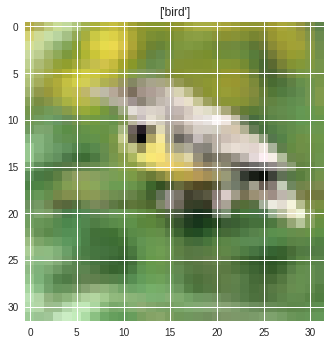

In [18]:
CLASS_LABELS = np.array(['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

train_set_size = x_train.shape[0]
# idx = 1000
idx = np.random.randint(train_set_size)
# idx = 2395
label = CLASS_LABELS[y_train[idx, :].astype(bool)]
plt.imshow(x_train[idx, :, :, :])
plt.title(label)


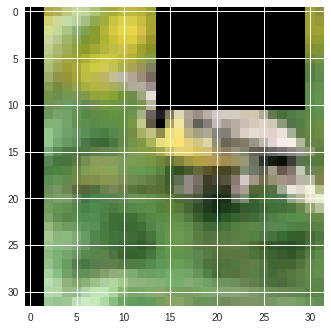

In [19]:
# !ls models/research/autoaugment
plt.imshow(preprocessing_function(x_train[idx, :, :, :]))

In [18]:
if use_tpu:
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    using_single_core = False
    tpu_cluster_resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
    strategy = tf.contrib.tpu.TPUDistributionStrategy(tpu_cluster_resolver, using_single_core=using_single_core)
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy=strategy)

train_data = ImageDataGenerator(featurewise_center=True, 
                                featurewise_std_normalization=True, 
                                width_shift_range=width_shift_range, 
                                height_shift_range=height_shift_range, 
                                horizontal_flip=horizontal_flip,
                                preprocessing_function=preprocessing_function)
validation_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)
test_data = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True)

for data in (train_data, validation_data, test_data):
    data.fit(x_train)

learning_rate_callback = LearningRateScheduler(partial(getitem, tuple(take(epochs, concat(repeat(0.1, 60), repeat(0.02, 60), repeat(0.004, 40), repeat(0.0008))))))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
callbacks = [gdcp, learning_rate_callback]

INFO:tensorflow:Querying Tensorflow master (b'grpc://10.70.9.146:8470') for TPU system metadata.
2018-12-06 21:24:09,438 69 140155896297344: Querying Tensorflow master (b'grpc://10.70.9.146:8470') for TPU system metadata.
INFO:tensorflow:Found TPU system:
2018-12-06 21:24:09,470 69 140155896297344: Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
2018-12-06 21:24:09,474 69 140155896297344: *** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
2018-12-06 21:24:09,479 69 140155896297344: *** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
2018-12-06 21:24:09,483 69 140155896297344: *** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15003922203969386355)
2018-12-06 21:24:09,486 69 140155896297344: *** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 15003922203969386355)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:w

In [48]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)

steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_validation.shape[0] // batch_size

results = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=300,
                              initial_epoch=0,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 1/300
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_80'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_4_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_3_target_30')]
2018-12-06 01:03:23,731 183 139789618734976: New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id_80'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_4_10'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_3_target_30')]
INFO:tensorflow:Overriding default placeholder.
2018-12-06 01:03:23,759 183 139789618734976: Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.10000000149011612, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
2018-12-06 01:03:29,126 183 139789618734976: Cloning SGD {'lr': 0.10000000149011612, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping pla

In [20]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)

steps_per_epoch = x_train.shape[0] // batch_size
validation_steps = x_validation.shape[0] // batch_size

results = model.fit_generator(train_generator,
                              steps_per_epoch=steps_per_epoch,
                              epochs=300,
                              initial_epoch=290,
                              callbacks=callbacks,
                              validation_data=validation_generator,
                              validation_steps=validation_steps)

Epoch 291/300
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_4_20'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_3_target_60')]
2018-12-06 21:25:18,675 69 140155896297344: New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(16,), dtype=tf.int32, name='core_id0'), TensorSpec(shape=(16, 32, 32, 3), dtype=tf.float32, name='input_4_20'), TensorSpec(shape=(16, 10), dtype=tf.float32, name='dense_3_target_60')]
INFO:tensorflow:Overriding default placeholder.
2018-12-06 21:25:18,720 69 140155896297344: Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 0.0007999999797903001, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
2018-12-06 21:25:19,287 69 140155896297344: Cloning SGD {'lr': 0.0007999999797903001, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping plac

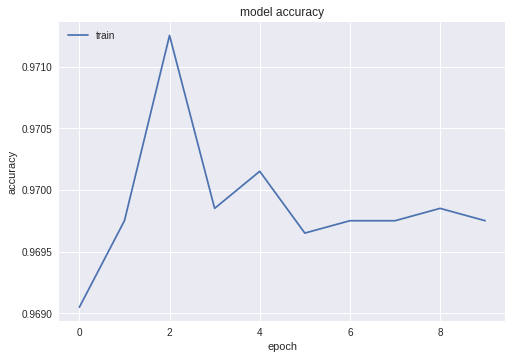

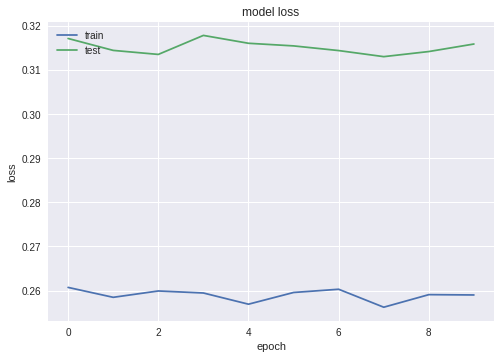

In [21]:
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
!git clone https://github.com/modestyachts/CIFAR-10.1.git  # Recht 2018 data

cifar101_data = np.load('CIFAR-10.1/datasets/cifar10.1_v6_data.npy')
cifar101_labels = np.load('CIFAR-10.1/datasets/cifar10.1_v6_labels.npy')
cifar101_set_size = len(cifar101_labels)
  
y_test = tf.keras.utils.to_categorical(cifar101_labels)
x_test = cifar101_data / 255

Cloning into 'CIFAR-10.1'...
remote: Enumerating objects: 510, done.
remote: Total 510 (delta 0), reused 0 (delta 0), pack-reused 510
Receiving objects: 100% (510/510), 11.23 MiB | 20.07 MiB/s, done.
Resolving deltas: 100% (344/344), done.


In [23]:
train_generator = train_data.flow(x_train, y_train, batch_size=batch_size)
validation_generator = validation_data.flow(x_validation, y_validation, batch_size=batch_size)
test_generator = test_data.flow(x_test, y_test, batch_size=batch_size)

loss, acc = model.evaluate_generator(train_generator)
logger.info("Train: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(validation_generator)
logger.info("Validation: Loss={}, acc={}".format(loss, acc))

loss, acc = model.evaluate_generator(test_generator)
logger.info("Test: Loss={}, acc={}".format(loss, acc))

INFO:tensorflow:New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='input_4_20'), TensorSpec(shape=(10, 10), dtype=tf.float32, name='dense_3_target_60')]
2018-12-06 21:45:21,255 69 140155896297344: New input shapes; (re-)compiling: mode=eval (# of cores 8), [TensorSpec(shape=(10,), dtype=tf.int32, name='core_id_10'), TensorSpec(shape=(10, 32, 32, 3), dtype=tf.float32, name='input_4_20'), TensorSpec(shape=(10, 10), dtype=tf.float32, name='dense_3_target_60')]
INFO:tensorflow:Overriding default placeholder.
2018-12-06 21:45:21,274 69 140155896297344: Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for input_4
2018-12-06 21:45:21,282 69 140155896297344: Remapping placeholder for input_4
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.SGD object at 0x7f78407435f8> []
2018-12-06 21:45:23,996 69 140155896297344: KerasCrossSh

Text(0.5,1,"920: ['deer']")

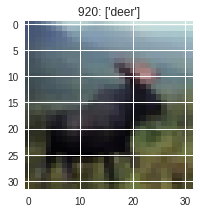

In [86]:
test_set_size = x_test.shape[0]
idx = np.random.randint(test_set_size)
# idx = 1113
label = CLASS_LABELS[y_test[idx, :].astype(bool)]
tit = "{}: {}".format(idx, label)
plt.figure(figsize=(3,4))
plt.imshow(x_test[idx, :, :, :])
plt.title(tit)

In [87]:
predictions = model.predict(x=x_test)

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='input_1_50')]
2018-12-05 07:54:24,762 118 140334049048448: New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(4, 32, 32, 3), dtype=tf.float32, name='input_1_50')]
INFO:tensorflow:Overriding default placeholder.
2018-12-05 07:54:24,769 118 140334049048448: Overriding default placeholder.
INFO:tensorflow:Cloning SGD {'lr': 3.199999991920777e-05, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
2018-12-05 07:54:37,016 118 140334049048448: Cloning SGD {'lr': 3.199999991920777e-05, 'momentum': 0.8999999761581421, 'decay': 0.0, 'nesterov': False}
INFO:tensorflow:Remapping placeholder for input_1
2018-12-05 07:54:37,042 118 140334049048448: Remapping placeholder for input_1
INFO:tensorflow:Started compiling
2018-12-05 07:54:38,321 118 140334049048448: Started compiling
INFO:tensorflow:Finished compiling. Time elapse

In [88]:
from collections import Counter
_ = np.argmax(predictions, axis=1)
Counter(_)
Counter(cifar101_labels)

Counter({0: 200,
         1: 200,
         2: 200,
         3: 200,
         4: 200,
         5: 200,
         6: 200,
         7: 200,
         8: 200,
         9: 200})

In [0]:
checkpoint_dir 
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)
!ls -ltra $checkpoint_dir

In [0]:
# with open('./results/history.pickle', 'wb') as f:
#     pickle.dump(results.history, f)

# save_model(model, './results/model.h5')
# del model